# Data Preparation

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime

import statsmodels.formula.api as sm
from sklearn.preprocessing import MinMaxScaler

import util_functions as uf

# Get Data

In [7]:
today = datetime.datetime.now()
end_date = datetime.datetime(today.year, today.month, today.day)
start_date = datetime.datetime(today.year-1, 1, 1)

In [8]:
df = uf.getdata('GOOG',[20, 50],'Close', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


# Remove NA

In [9]:
df = uf.data_preprocessing(df, 'Close')

# Remove Outliers

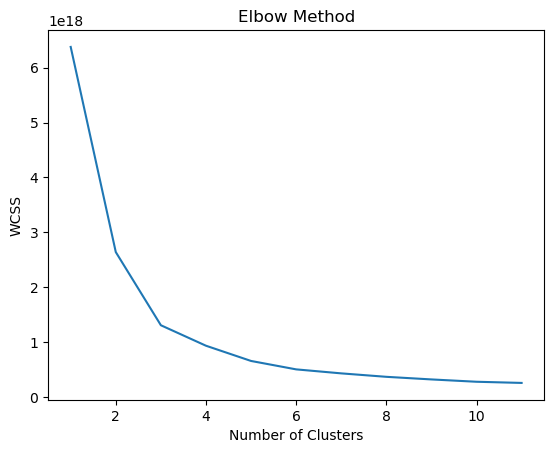

In [10]:
plot_k_clusters = uf.kmeans_elbow_method(df.drop(columns=['Date']))

In [11]:
df_outliers = uf.detect_outliers_kmeans(df.drop(columns='Date'), 4)

Number of outliers = 38


In [12]:
# Check for location of outliers
df[df.index.isin(df_outliers.index.tolist())][['Date','next_day_close']].groupby(pd.Grouper(key='Date', freq='M')).count()

,next_day_close
Date,
2023-03-31,4
2023-04-30,0
2023-05-31,12
2023-06-30,1
2023-07-31,1
2023-08-31,4
2023-09-30,6
2023-10-31,0
2023-11-30,0


In [13]:
df = df[~df.index.isin(df_outliers.index.tolist())]

# Scale df

In [14]:
df_x = df.drop(columns=['Date','next_day_close'])
df_y = df[['next_day_close']]

In [15]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [16]:
df_scaled_x, df_scaled_y = uf.df_min_max_scaler(df_x, df_y, scaler_x, scaler_y)

# PCA - reduce dimensionality

In [17]:
df_scaled_x.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma_20', 'ema_20', 'wma_20',
       'sma_50', 'ema_50', 'wma_50', 'upper_band', 'middle_band', 'Lower_band',
       'bb_width', 'bb_percent', 'obv', 'vwap', 'adl', 'adx', 'macd',
       'ichimoku_a', 'ichimoku_b', 'rsi', 'stoch', 'cci', 'roc', 'atr', 'kc',
       'uo', 'wr', 'doji', 'hammer', 'engulfing', 'harami'],
      dtype='object')

In [18]:
df_pca_full_x = uf.apply_PCA(df_scaled_x)

# df

In [19]:
df = pd.concat([df_pca_full_x, df_scaled_y], axis=1)

# Feature engineering

In [20]:
# Calculate the correlation coefficients between market indicators and stock prices
correlation_matrix = df.corr()
correlation_with_stock_prices = correlation_matrix['next_day_close'].dropna()
relevant_indicators = correlation_with_stock_prices[abs(correlation_with_stock_prices) > 0.5].index.tolist()

# Identify relevant indicators

In [21]:
relevant_indicators

['PCA0', 'next_day_close']

In [22]:
relevant_indicators = df.columns

# Train Model

In [23]:
# Check for NaN values
nan_locations = df.isna().any()

# Get the columns with NaN values
columns_with_nan = nan_locations[nan_locations].index.tolist()

# Get the rows with NaN values
rows_with_nan = df[df.isna().any(axis=1)].index.tolist()


In [24]:
df = df.fillna(0)

# Check for overfitting

In [25]:
import warnings
warnings.filterwarnings("ignore")

# Set the window size and step size for cross-validation
uf.check_overfitting(df, relevant_indicators, scaler_y, window_size=100, step_size=10)

Remove PCA0 = [45.3307, 194.9623, 74.618, 93.3034, 15.1153, 66.6373, 42.5157, 11.1633, 57.5277, 16.0378, 10.2121, 9.1785]
[25.7254, 24.5104, 27.1935, 24.4383, 17.8521, 16.894, 18.9532, 7.9448, 5.667, 7.2569, 8.0807, 8.1453]
Remove PCA1 = [12.9363, 24.8259, 156.3331, 18.9343, 48.1627, 13.7689, 15.0473, 4.2551, 32.0337, 5.9214, 40.2949, 31.0892]
[8.1522, 8.7426, 9.6716, 18.2135, 15.4335, 18.4957, 17.0972, 12.3205, 8.9033, 9.9273, 10.037, 10.6269]
Remove PCA2 = [3.5854, 5.0232, 42.1216, 2.7127, 2.4079, 6.8927, 9.2425, 12.0118, 30.3724, 9.5959, 22.7694, 8.7712]
[3.6604, 3.6023, 3.538, 5.9634, 5.7583, 5.2346, 5.1016, 4.9656, 5.6471, 6.4721, 6.4176, 7.1985]
Remove PCA3 = [3.741, 5.2085, 38.1509, 5.6315, 2.6247, 6.6971, 3.5748, 6.3515, 40.1983, 7.3554, 16.7345, 9.543]
[3.6465, 3.6191, 3.5528, 5.5561, 5.2212, 4.9824, 5.2359, 4.4909, 4.5989, 5.8574, 5.7857, 6.3111]
Remove PCA4 = [3.4615, 4.8918, 39.0041, 1.9061, 1.3171, 7.4818, 2.7313, 4.6701, 27.0162, 4.4361, 17.1725, 9.3723]
[3.6659, 3.6038, 

In [26]:
#df = df[relevant_indicators].drop(columns='Close')

# Find Best Order

In [27]:
train_size = int(len(df) * 0.8)  # 80% for training
train_data = df[:train_size]
test_data = df[train_size:]

# ARIMA Model Prediction

In [28]:
uf.find_best_order_arima_accuracy(train_data, test_data, df_y, train_size, scaler_y)

Accuracy of best order (2,1,2) = 0.6363636363636364


In [31]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score

train_data_endog = train_data['next_day_close']
train_data_exog = train_data.drop(columns='next_day_close')

test_data_endog = test_data['next_day_close']
test_data_exog = test_data.drop(columns='next_day_close')

best_accuracy=0
for p in range(3):
        for d in range(2):
                for q in range(3):
                        model = ARIMA(endog=train_data_endog, exog=train_data_exog, order=(p,d,q))
                        model_fit = model.fit()

                        # Forecast on the test data
                        forecast = model_fit.get_forecast(steps=len(test_data), exog=test_data_exog)

                        # Get the predicted values
                        predicted_values = forecast.predicted_mean
                        val_predictions_mean = predicted_values.values.reshape(-1,1)
                        test_pred = scaler_y.inverse_transform(val_predictions_mean)
                        test_pred_series = pd.Series(test_pred.flatten())

                        # Calculate the price change from the predicted values
                        predicted_price_change = test_pred_series.diff()

                        # Create a binary target variable indicating if the price change is positive (1) or not (0)
                        predicted_price_up = (predicted_price_change > 0).astype(int)

                        # Calculate the actual price change from the test data
                        actual_price_change = df_y[train_size:].diff()

                        # Create a binary target variable for the actual price change
                        actual_price_up = (actual_price_change > 0).astype(int)

                        # Calculate the accuracy of the predictions
                        accuracy = accuracy_score(actual_price_up, predicted_price_up)

                        if best_accuracy<accuracy:
                                best_accuracy = accuracy

                                best_p, best_d, best_q = p,d,q
#Print the accuracy
print(f"Accuracy of best order ({best_p},{best_d},{best_q}) = {best_accuracy}")

Accuracy of best order (2,1,2) = 0.6363636363636364


# SARIMA Model Prediction

In [30]:
uf.find_best_order_sarimax_accuracy(train_data, test_data, df_y, train_size, scaler_y)

KeyboardInterrupt: 